In [3]:
!pip install transformers
!pip install torch
!pip install sklearn
!pip install sentencepiece
!pip install joblib

  Using cached sklearn-0.0.post9.tar.gz (3.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [4]:
# Basic libraries
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import joblib

# PyTorch utilities
from torch.utils.data import DataLoader, TensorDataset, random_split

# Transformers utilities
from transformers import (
    AdamW,
    get_linear_schedule_with_warmup,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    RobertaTokenizer,
    BertTokenizer,
    BertForSequenceClassification,
    RobertaForSequenceClassification,
    XLNetTokenizer,
    XLNetForSequenceClassification
)

In [5]:
data = pd.read_csv('drive/MyDrive/uolfp/full_dataset_504.csv')
data['text'] = data['title'] + " " + data['body']
# Replace NaN in 'text' column with 'UNKNOWN'
data['text'].fillna('UNKNOWN', inplace=True)
data = data[['text', 'label']]

In [6]:
data = data.reset_index(drop=True)

In [7]:
data

,text,label
0,یک توصیه‌ مهم به افراد کم‌تحرک پزشکان بر اساس ...,0
1,آزمایش DNA روی مومیایی‌های سه‌انگشتی در پرو نش...,1
2,سارق حرفه‌ای خودرو در دام پلیس رئیس پایگاه دوم...,0
3,هشدار: زیتون سیاه نخرید! ایسنا: يک کارشناس کشا...,0
4,نه فقط ما که تمام دنیا روی لباس حساس هستند. در...,1
...,...,...
499,برای دریافت تاییدیه کد پستی چه باید کرد؟ به گز...,0
500,زن اسیدپاش در یک قدمی چوبه دار حکم قصاص زن جوا...,0
501,واکسن‌های کرونا در بدن خاصیت آهن‌ربایی ایجاد م...,1
502,واردات گوشت چرخ‌کرده از بدن مردگان چینی به ایر...,1


In [8]:
# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(data['text'], data['label'], test_size=0.1)
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

In [9]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# BERT multilingual
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2).to(device)

# Persian RoBERTa
model_name_or_path = "HooshvareLab/roberta-fa-zwnj-base"
persian_tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
persian_model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path, num_labels=2).to(device)

# XLNet (assuming no specific Persian model is available, so using the base model)
xlnet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
xlnet_model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/roberta-fa-zwnj-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Tokenize the dataset and prepare DataLoader
def create_dataloader(texts, labels, tokenizer, batch_size=16):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=256,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    dataset = TensorDataset(input_ids, attention_masks, labels)

    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
# Tokenize the dataset and prepare DataLoader
bert_train_dataloader = create_dataloader(train_texts, train_labels, bert_tokenizer, batch_size=64)
bert_validation_dataloader = create_dataloader(val_texts, val_labels, bert_tokenizer, batch_size=64)

persian_train_dataloader = create_dataloader(train_texts, train_labels, persian_tokenizer, batch_size=64)
persian_validation_dataloader = create_dataloader(val_texts, val_labels, persian_tokenizer, batch_size=64)

xlnet_train_dataloader = create_dataloader(train_texts, train_labels, xlnet_tokenizer, batch_size=64)
xlnet_validation_dataloader = create_dataloader(val_texts, val_labels, xlnet_tokenizer, batch_size=64)

In [13]:
def extract_features(model, tokenizer, texts):
    features = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256).to(device)
        logits = model(**inputs).logits
        extracted_logits = logits.cpu().detach().numpy()[0]

        # Assertion to ensure each text always results in 2 logits (features)
        assert len(extracted_logits) == 2, f"Expected 2 features, but got {len(extracted_logits)} for text: {text}"

        features.append(extracted_logits)
    return features

In [14]:
def fine_tune_model(model, train_dataloader, validation_dataloader, epochs=3, lr=2e-5):
    device = torch.device("cuda")
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_dataloader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)

            model.zero_grad()
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs[0]
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch + 1}, Training loss: {avg_train_loss}")

        model.eval()
        eval_loss = 0
        for batch in validation_dataloader:
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)

            with torch.no_grad():
                outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs[0]
            eval_loss += loss.item()
        avg_eval_loss = eval_loss / len(validation_dataloader)
        print(f"Epoch {epoch + 1}, Validation loss: {avg_eval_loss}")

    return model

In [15]:
# Ensemble predict function
def ensemble_predict(texts):
    combined_features = []
    for text in texts:
        features = []
        for model_name, model in models.items():
            tokenizer = tokenizers[model_name]
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256).to(device)
            logits = model(**inputs).logits
            features.extend(logits.cpu().detach().numpy()[0])
        combined_features.append(features)

    return clf.predict(combined_features)

In [16]:
# Evaluate function
def evaluate(model, tokenizer, dataloader):
    model.eval()
    total = 0
    correct = 0

    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = inputs['labels'].cpu().numpy()

            correct += (preds == labels).sum()
            total += labels.shape[0]

    return correct / total

In [17]:
# Extract features from models and train the ensemble classifier (clf)
def train_ensemble_classifier(models, tokenizers, texts, labels):
    combined_features = []
    for text in texts:
        features = []
        for model_name, model in models.items():
            tokenizer = tokenizers[model_name]
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256).to(device)
            logits = model(**inputs).logits
            features.extend(logits.cpu().detach().numpy()[0])
        combined_features.append(features)

    clf = LogisticRegression(max_iter=10000)
    clf.fit(combined_features, labels)
    return clf

In [18]:
# Models and Tokenizers
models = {
    "BERT": bert_model,
    "RoBERTa": persian_model,
    "XLNet": xlnet_model
}

tokenizers = {
    "BERT": bert_tokenizer,
    "RoBERTa": persian_tokenizer,
    "XLNet": xlnet_tokenizer
}

# Placeholder for recording performance
performance = {
    "BERT": [],
    "RoBERTa": [],
    "XLNet": [],
    "Ensemble": []
}

Training Epoch: 1
Training BERT...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training loss: 0.6543281823396683
Epoch 1, Validation loss: 0.6104494333267212
Training RoBERTa...
Epoch 1, Training loss: 0.6421629339456558
Epoch 1, Validation loss: 0.58338862657547
Training XLNet...
Epoch 1, Training loss: 0.694013848900795
Epoch 1, Validation loss: 0.6294028162956238
Length of BERT features: 51
Length of RoBERTa features: 51
Length of XLNet features: 51
First 5 combined features:
[ 0.19518368 -0.11120611 -0.01791498 -0.06942744  0.15735245  0.5106606 ]
[ 0.08741207 -0.05334206  0.09921965 -0.15325958  0.4564879   0.14876576]
[-0.19820842  0.04583461 -0.25452128  0.26623237  0.4572695   0.22759108]
[-0.13346496  0.04707716 -0.29164922  0.08973961  0.13399547  0.5071615 ]
[ 0.2905315  -0.08686545  0.05614857  0.02819752  0.41135898  0.2598239 ]
Training Epoch: 2
Training BERT...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training loss: 0.5154887549579144
Epoch 1, Validation loss: 0.4228314459323883
Training RoBERTa...
Epoch 1, Training loss: 0.513007678091526
Epoch 1, Validation loss: 0.4192006587982178
Training XLNet...
Epoch 1, Training loss: 0.7195822894573212
Epoch 1, Validation loss: 0.6966714262962341
Length of BERT features: 51
Length of RoBERTa features: 51
Length of XLNet features: 51
First 5 combined features:
[ 0.3210434   0.05960294  0.14001088 -0.25284722  0.46298954  0.30696067]
[ 0.36053064  0.05386822  0.5245063  -0.6061979   0.5010187   0.27972448]
[-1.059546    0.73684424 -0.763511    0.73399675  0.49741006  0.277737  ]
[-1.0354068   0.7667539  -0.76667833  0.5000435   0.4921864   0.28993556]
[ 0.46136576 -0.1210345   0.2440683  -0.19438443  0.55905646  0.25282994]
Training Epoch: 3
Training BERT...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training loss: 0.4200700856745243
Epoch 1, Validation loss: 0.3553551733493805
Training RoBERTa...
Epoch 1, Training loss: 0.3171289283782244
Epoch 1, Validation loss: 0.26675945520401
Training XLNet...
Epoch 1, Training loss: 0.6857029497623444
Epoch 1, Validation loss: 0.5751084089279175
Length of BERT features: 51
Length of RoBERTa features: 51
Length of XLNet features: 51
First 5 combined features:
[ 0.42116925 -0.06846249  0.52635497 -0.7086984   0.25621018  0.4936117 ]
[ 0.53774    -0.11032061  1.356906   -1.5107068   0.60264355  0.05040991]
[-1.5131384   1.1550195  -1.6389278   1.5405666   0.24251933  0.4329909 ]
[-1.4809924   1.1661698  -1.6703007   1.3342149   0.24651755  0.46622676]
[ 0.609677   -0.24934116  0.8015116  -0.8272634   0.20973301  0.48758668]
Training Epoch: 4
Training BERT...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training loss: 0.40257394313812256
Epoch 1, Validation loss: 0.34430190920829773
Training RoBERTa...
Epoch 1, Training loss: 0.1959715187549591
Epoch 1, Validation loss: 0.15903885662555695
Training XLNet...
Epoch 1, Training loss: 0.7298941761255264
Epoch 1, Validation loss: 0.6884756088256836
Length of BERT features: 51
Length of RoBERTa features: 51
Length of XLNet features: 51
First 5 combined features:
[ 0.6033377  -0.322259    0.50331163 -0.71314615  0.2193618   0.48068324]
[ 0.84457225 -0.54012334  1.9342798  -2.07181     0.22043316  0.47886735]
[-1.5689297   1.2051204  -2.4133327   2.343555    0.21913879  0.47998762]
[-1.4226867   1.1583847  -2.531116    2.2556067   0.21924381  0.4799598 ]
[ 0.93186325 -0.5321005   1.322492   -1.3572046   0.21944837  0.48029718]
Training Epoch: 5
Training BERT...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training loss: 0.3343793973326683
Epoch 1, Validation loss: 0.28753286600112915
Training RoBERTa...
Epoch 1, Training loss: 0.11593472398817539
Epoch 1, Validation loss: 0.08410661667585373
Training XLNet...
Epoch 1, Training loss: 0.689442090690136
Epoch 1, Validation loss: 0.6708427667617798
Length of BERT features: 51
Length of RoBERTa features: 51
Length of XLNet features: 51
First 5 combined features:
[ 0.57720584 -0.09284511  0.02537671 -0.27232853  0.33996484  0.34393856]
[ 0.9554184  -0.5140515   2.2258964  -2.367786    0.41914472  0.27119747]
[-1.8942504   1.5052773  -2.8519208   2.7836158   0.33954492  0.34004843]
[-1.8613226   1.5752394  -2.971315    2.7267916   0.33538035  0.34840125]
[ 0.9144172  -0.5229015   1.8172148  -1.8722999   0.33968058  0.34500304]
Training Epoch: 6
Training BERT...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training loss: 0.24568408355116844
Epoch 1, Validation loss: 0.20751504600048065
Training RoBERTa...
Epoch 1, Training loss: 0.0907142354408279
Epoch 1, Validation loss: 0.05651741102337837
Training XLNet...
Epoch 1, Training loss: 0.6064205318689346
Epoch 1, Validation loss: 0.4393561780452728
Length of BERT features: 51
Length of RoBERTa features: 51
Length of XLNet features: 51
First 5 combined features:
[ 0.3840632   0.03326297 -0.4112742   0.15777327 -0.01926326  0.65924186]
[ 1.0920994  -0.75263065  2.401791   -2.554654    1.2702396  -0.43224323]
[-2.0522754   1.6512437  -2.9796798   2.9042084  -0.11446033  0.6688081 ]
[-2.0429695   1.7312441  -3.104966    2.8601096  -0.09624746  0.75341046]
[ 1.3851345  -0.90025294  2.264228   -2.3348649  -0.10793716  0.72027767]
Training Epoch: 7
Training BERT...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training loss: 0.18438586965203285
Epoch 1, Validation loss: 0.1997443586587906
Training RoBERTa...
Epoch 1, Training loss: 0.03922880545724183
Epoch 1, Validation loss: 0.04678937420248985
Training XLNet...
Epoch 1, Training loss: 0.5456877499818802
Epoch 1, Validation loss: 0.4573236107826233
Length of BERT features: 51
Length of RoBERTa features: 51
Length of XLNet features: 51
First 5 combined features:
[ 0.14797302  0.19694495 -1.1789482   0.9248131  -0.36979407  0.87745315]
[ 1.5065314  -1.1528783   2.8858628  -3.0129318   0.23230338 -0.7756939 ]
[-2.106976    1.7141047  -3.2860708   3.209761   -0.48419225  0.92066914]
[-2.1956732   1.8816503  -3.3820267   3.159822   -0.54414284  1.1304022 ]
[ 1.5977497  -1.0896548   2.5864627  -2.63988    -0.45108423  0.9779359 ]
Training Epoch: 8
Training BERT...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training loss: 0.11528027709573507
Epoch 1, Validation loss: 0.15316732227802277
Training RoBERTa...
Epoch 1, Training loss: 0.03983785479795188
Epoch 1, Validation loss: 0.08861585706472397
Training XLNet...
Epoch 1, Training loss: 0.49063025787472725
Epoch 1, Validation loss: 0.403848797082901
Length of BERT features: 51
Length of RoBERTa features: 51
Length of XLNet features: 51
First 5 combined features:
[-0.61079377  0.93405366 -2.3035355   2.0893736  -0.29158667  0.8899044 ]
[ 1.646265  -1.403573   3.1956375 -3.3115764  1.3100257 -0.8909101]
[-2.4426167   2.0066705  -3.4815798   3.4081166  -0.45559883  1.0588118 ]
[-2.4497018  2.1143212 -3.561378   3.3531334 -0.8060591  1.5281209]
[ 1.8935812 -1.3785678  2.951776  -3.0003076 -0.3452143  0.8569324]
Training Epoch: 9
Training BERT...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training loss: 0.11267294408753514
Epoch 1, Validation loss: 0.14239148795604706
Training RoBERTa...
Epoch 1, Training loss: 0.02492608572356403
Epoch 1, Validation loss: 0.0621444471180439
Training XLNet...
Epoch 1, Training loss: 0.5262394361197948
Epoch 1, Validation loss: 0.4017770290374756
Length of BERT features: 51
Length of RoBERTa features: 51
Length of XLNet features: 51
First 5 combined features:
[-0.9291716   1.0246488  -2.3989477   2.202876    0.02625421  0.5050535 ]
[ 1.9210337 -1.4666969  3.3267555 -3.442412   1.0821753 -1.0062655]
[-2.6062884   2.1581502  -3.4996426   3.4232993  -0.1111115   0.68735564]
[-2.6529937   2.2915316  -3.59863     3.3884306  -0.27655765  0.87830615]
[ 1.7112641  -1.2665771   3.0804424  -3.113988   -0.11750182  0.61454135]
Training Epoch: 10
Training BERT...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training loss: 0.14521815301850438
Epoch 1, Validation loss: 0.23660655319690704
Training RoBERTa...
Epoch 1, Training loss: 0.007930999476229772
Epoch 1, Validation loss: 0.02283453196287155
Training XLNet...
Epoch 1, Training loss: 0.47488605976104736
Epoch 1, Validation loss: 0.3899737000465393
Length of BERT features: 51
Length of RoBERTa features: 51
Length of XLNet features: 51
First 5 combined features:
[ 0.14150177  0.1405212  -2.4563675   2.2888238  -0.23470052  0.9204723 ]
[ 2.4007168 -1.9840058  3.660708  -3.7635486  1.5892481 -0.6165022]
[-2.5779035   2.1661222  -3.7056453   3.6420844  -0.48614296  1.128251  ]
[-2.6734164  2.334577  -3.80335    3.6150377 -0.6285625  1.2484907]
[ 2.5394828  -1.94685     3.5627322  -3.5883596  -0.22145675  0.78798276]
Training Epoch: 11
Training BERT...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training loss: 0.06353158922865987
Epoch 1, Validation loss: 0.19405968487262726
Training RoBERTa...
Epoch 1, Training loss: 0.002739206058322452
Epoch 1, Validation loss: 0.0026440562214702368
Training XLNet...
Epoch 1, Training loss: 0.4353410303592682
Epoch 1, Validation loss: 0.3622094988822937
Length of BERT features: 51
Length of RoBERTa features: 51
Length of XLNet features: 51
First 5 combined features:
[ 0.97322005 -0.35073307 -2.0341547   1.8513384   0.65228045 -0.24129075]
[ 2.4663062 -1.9254255  4.0478077 -4.1234384  1.8012975 -1.1936477]
[-2.8825064   2.4431868  -3.9181051   3.8604593   0.51442325 -0.09061306]
[-2.8495586  2.4653425 -4.0005035  3.8228285 -0.4327139  1.0515248]
[ 2.4795842  -1.8747877   3.9800012  -3.987961    0.83056533 -0.5048828 ]
Training Epoch: 12
Training BERT...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training loss: 0.08261138433590531
Epoch 1, Validation loss: 0.27971354126930237
Training RoBERTa...
Epoch 1, Training loss: 0.0010125459739356302
Epoch 1, Validation loss: 0.002334635704755783
Training XLNet...
Epoch 1, Training loss: 0.5101200379431248
Epoch 1, Validation loss: 0.4099826514720917
Length of BERT features: 51
Length of RoBERTa features: 51
Length of XLNet features: 51
First 5 combined features:
[ 1.3232627  -0.6511282  -2.7065043   2.5586295  -0.38028258  0.87059546]
[ 2.7120903 -2.1531982  4.258669  -4.326767   1.5420866 -1.321947 ]
[-2.7712436   2.4004147  -4.16373     4.1082625  -0.46762663  1.1533889 ]
[-2.8626704  2.5604022 -4.238515   4.075235  -0.5185158  0.902229 ]
[ 2.8346913  -2.1774483   4.195624   -4.1972957  -0.10336178  0.5289698 ]
Training Epoch: 13
Training BERT...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training loss: 0.043122225906699896
Epoch 1, Validation loss: 0.18412479758262634
Training RoBERTa...
Epoch 1, Training loss: 0.0006047032184142154
Epoch 1, Validation loss: 0.0009984294883906841
Training XLNet...
Epoch 1, Training loss: 0.4094097316265106
Epoch 1, Validation loss: 0.31152039766311646
Length of BERT features: 51
Length of RoBERTa features: 51
Length of XLNet features: 51
First 5 combined features:
[ 0.7804586  -0.08774101 -2.8609633   2.7162526  -0.29584813  0.8182636 ]
[ 2.8721962  -2.2636468   4.437983   -4.4992375   1.6571566  -0.85775054]
[-3.0256581   2.5721366  -4.3408504   4.284442   -0.76112044  1.1888015 ]
[-3.0005412  2.6244438 -4.4126344  4.2533355 -0.8967837  1.0566757]
[ 2.9275181  -2.2544804   4.388073   -4.3854175   0.09825615  0.23205858]
Training Epoch: 14
Training BERT...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training loss: 0.017490903148427606
Epoch 1, Validation loss: 0.1724904179573059
Training RoBERTa...
Epoch 1, Training loss: 0.0004204065517114941
Epoch 1, Validation loss: 0.0008993085939437151
Training XLNet...
Epoch 1, Training loss: 0.33384903706610203
Epoch 1, Validation loss: 0.32309895753860474
Length of BERT features: 51
Length of RoBERTa features: 51
Length of XLNet features: 51
First 5 combined features:
[-0.9710113  1.2728868 -3.109054   2.9759793 -0.6588082  1.3067406]
[ 3.0252302 -2.5690324  4.5804615 -4.6361814  2.0164614 -1.27501  ]
[-3.3386352   2.8562224  -4.4836817   4.4251833  -0.94994307  1.6135699 ]
[-3.2896383  2.8989804 -4.551641   4.3955517 -1.3032496  1.7037488]
[ 3.190216  -2.6410732  4.5328035 -4.5260425  0.974168  -0.2767962]
Training Epoch: 15
Training BERT...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training loss: 0.05012210155837238
Epoch 1, Validation loss: 0.22076202929019928
Training RoBERTa...
Epoch 1, Training loss: 0.00032421897776657715
Epoch 1, Validation loss: 0.0010051842546090484
Training XLNet...
Epoch 1, Training loss: 0.3983297720551491
Epoch 1, Validation loss: 0.27445751428604126
Length of BERT features: 51
Length of RoBERTa features: 51
Length of XLNet features: 51
First 5 combined features:
[-1.2554312  1.6431826 -3.3155465  3.1921902 -0.8596974  1.3816754]
[ 3.1719282 -2.6287088  4.7028527 -4.7537203  1.9886072 -1.5933421]
[-3.3223813  2.8717027 -4.6089573  4.5494795 -1.3246107  1.9897718]
[-3.335418   2.9531245 -4.6735597  4.52109   -1.4198288  2.0615187]
[ 3.2349217  -2.5917702   4.6578035  -4.647531    0.83679503 -0.24063428]
Training Epoch: 16
Training BERT...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training loss: 0.018110364442691207
Epoch 1, Validation loss: 0.26938384771347046
Training RoBERTa...
Epoch 1, Training loss: 0.00026476049424672965
Epoch 1, Validation loss: 0.0007075936300680041
Training XLNet...
Epoch 1, Training loss: 0.4711449518799782
Epoch 1, Validation loss: 0.29658690094947815
Length of BERT features: 51
Length of RoBERTa features: 51
Length of XLNet features: 51
First 5 combined features:
[-2.4870603   2.3078     -3.4164374   3.296791   -0.84337544  1.6742917 ]
[ 3.3583398 -2.814734   4.8094664 -4.856638   1.8739227 -1.2732975]
[-3.5237272  3.0646553 -4.7105565  4.6497416 -1.1544734  1.9797664]
[-3.4963999  3.1009712 -4.7736697  4.622497  -1.2941092  2.0131567]
[ 3.4680228  -2.815349    4.7673173  -4.754639   -0.03746565  0.8863597 ]
Training Epoch: 17
Training BERT...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training loss: 0.008440024044830352
Epoch 1, Validation loss: 0.24523501098155975
Training RoBERTa...
Epoch 1, Training loss: 0.0002118777028954355
Epoch 1, Validation loss: 0.0004786359204445034
Training XLNet...
Epoch 1, Training loss: 0.3137369155883789
Epoch 1, Validation loss: 0.22036528587341309
Length of BERT features: 51
Length of RoBERTa features: 51
Length of XLNet features: 51
First 5 combined features:
[-2.175746    2.2895706  -3.4920225   3.3737824  -0.6629582   0.71820205]
[ 3.5062044 -2.9237678  4.90069   -4.94483    1.0250057 -1.0278475]
[-3.659697   3.2012374 -4.801237   4.7394085 -1.6180767  1.5760595]
[-3.6692228  3.2701256 -4.863268   4.7130823 -1.877189   1.7841663]
[ 3.4837227 -2.8114357  4.8616147 -4.8469167  0.9278586 -1.1190526]
Training Epoch: 18
Training BERT...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training loss: 0.0028995626198593527
Epoch 1, Validation loss: 0.19464616477489471
Training RoBERTa...
Epoch 1, Training loss: 0.00017744122123986017
Epoch 1, Validation loss: 0.0006079807644709945
Training XLNet...
Epoch 1, Training loss: 0.384319381788373
Epoch 1, Validation loss: 0.2305554896593094
Length of BERT features: 51
Length of RoBERTa features: 51
Length of XLNet features: 51
First 5 combined features:
[-1.2992796  1.6261613 -3.6415498  3.5284207 -1.7355274  1.5035949]
[ 3.7239668 -3.1887457  4.979217  -5.0208845  1.6696965 -1.0572475]
[-3.8224266  3.3734705 -4.88384    4.8201413 -2.1056373  1.9334089]
[-3.8484604  3.4504943 -4.94431    4.7945714 -2.4483006  1.9875422]
[ 3.8328836  -3.1840477   4.9405274  -4.9237013   0.5473572  -0.61128694]
Training Epoch: 19
Training BERT...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training loss: 0.0028719218098558486
Epoch 1, Validation loss: 0.2600283920764923
Training RoBERTa...
Epoch 1, Training loss: 0.00015737544345029164
Epoch 1, Validation loss: 0.0011370868887752295
Training XLNet...
Epoch 1, Training loss: 0.29014687053859234
Epoch 1, Validation loss: 0.23881809413433075
Length of BERT features: 51
Length of RoBERTa features: 51
Length of XLNet features: 51
First 5 combined features:
[-2.663228   2.7046971 -3.8015678  3.6952958 -0.9197192  0.8506523]
[ 3.8977792 -3.3588583  5.052965  -5.0926566  2.4923642 -1.7932934]
[-4.0047917  3.525459  -4.9617553  4.8961577 -1.0804377  1.4208516]
[-4.015888   3.583385  -5.019986   4.870831  -1.7267189  1.8638009]
[ 3.9769707 -3.3064182  5.0130157 -4.9944577  1.3798277 -1.1230103]
Training Epoch: 20
Training BERT...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training loss: 0.0017824352398747578
Epoch 1, Validation loss: 0.21717186272144318
Training RoBERTa...
Epoch 1, Training loss: 0.0001172732881968841
Epoch 1, Validation loss: 0.0008937437669374049
Training XLNet...
Epoch 1, Training loss: 0.24273582268506289
Epoch 1, Validation loss: 0.24330417811870575
Length of BERT features: 51
Length of RoBERTa features: 51
Length of XLNet features: 51
First 5 combined features:
[-0.42837462  0.8550021  -3.8689346   3.7635493  -1.4092641   1.0257759 ]
[ 4.0654387 -3.5246716  5.120422  -5.157848   2.016244  -1.7958361]
[-4.1091275   3.6406536  -5.028507    4.9616246  -1.0368358   0.71355087]
[-4.1240697  3.6970575 -5.085713   4.936781  -2.4274395  2.3185613]
[ 4.126878  -3.4496126  5.0820217 -5.061994   1.2135003 -1.7448971]


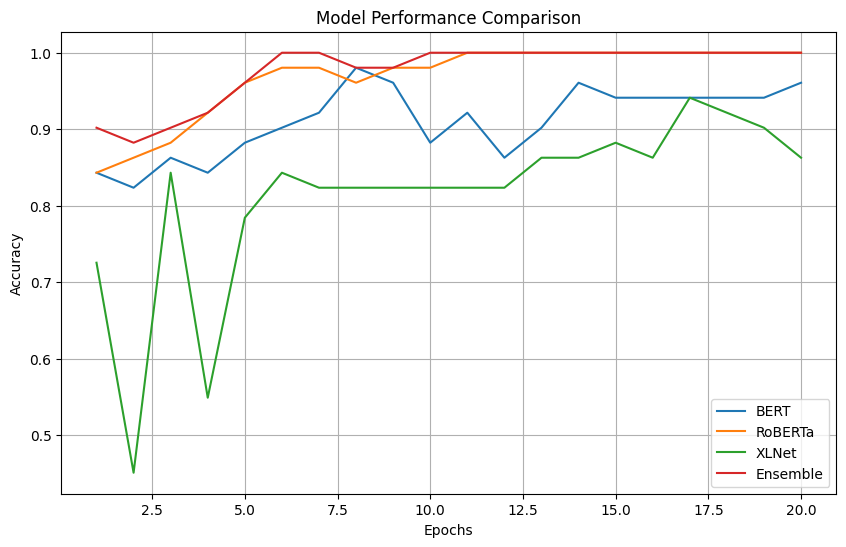

In [19]:
for epoch in range(1, 21):
    print(f"Training Epoch: {epoch}")

    # Fine-tune BERT
    print("Training BERT...")
    bert_model = fine_tune_model(bert_model, bert_train_dataloader, bert_validation_dataloader, epochs=1)
    acc_bert = evaluate(bert_model, bert_tokenizer, bert_validation_dataloader)
    performance["BERT"].append(acc_bert)

    # Fine-tune RoBERTa
    print("Training RoBERTa...")
    persian_model = fine_tune_model(persian_model, persian_train_dataloader, persian_validation_dataloader, epochs=1)
    acc_roberta = evaluate(persian_model, persian_tokenizer, persian_validation_dataloader)
    performance["RoBERTa"].append(acc_roberta)

    # Fine-tune XLNet
    print("Training XLNet...")
    xlnet_model = fine_tune_model(xlnet_model, xlnet_train_dataloader, xlnet_validation_dataloader, epochs=1)
    acc_xlnet = evaluate(xlnet_model, xlnet_tokenizer, xlnet_validation_dataloader)
    performance["XLNet"].append(acc_xlnet)

    # Now, for the ensemble:
    bert_features_train = extract_features(bert_model, bert_tokenizer, train_texts)
    persian_features_train = extract_features(persian_model, persian_tokenizer, train_texts)
    xlnet_features_train = extract_features(xlnet_model, xlnet_tokenizer, train_texts)

    # Stack the features together
    combined_features_train = [bert + persian + xlnet for bert, persian, xlnet in zip(bert_features_train, persian_features_train, xlnet_features_train)]

    # Train clf on training set
    clf = train_ensemble_classifier(models, tokenizers, train_texts, train_labels)

    # For the evaluation part:
    bert_features_val = extract_features(bert_model, bert_tokenizer, val_texts)
    persian_features_val = extract_features(persian_model, persian_tokenizer, val_texts)
    xlnet_features_val = extract_features(xlnet_model, xlnet_tokenizer, val_texts)

    # Stack the features together
    combined_features_val = [np.concatenate([bert, persian, xlnet]) for bert, persian, xlnet in zip(bert_features_val, persian_features_val, xlnet_features_val)]

    # Assertion to ensure concatenated features always result in 6 features
    for features in combined_features_val:
        assert len(features) == 6, f"Expected 6 features, but got {len(features)} for combined features: {features}"


    # Evaluate ensemble performance
    ensemble_acc = accuracy_score(val_labels, clf.predict(combined_features_val))
    performance["Ensemble"].append(ensemble_acc)

    # Save models:
    bert_model.save_pretrained(f"drive/MyDrive/uolfp/bert_model_epoch_{epoch}")
    persian_model.save_pretrained(f"drive/MyDrive/uolfp/roberta_model_epoch_{epoch}")
    xlnet_model.save_pretrained(f"drive/MyDrive/uolfp/xlnet_model_epoch_{epoch}")
    joblib.dump(clf, f"drive/MyDrive/uolfp/clf_model_epoch_{epoch}.pkl")

    # If needed, clear the memory to ensure no memory issues
    # torch.cuda.empty_cache()



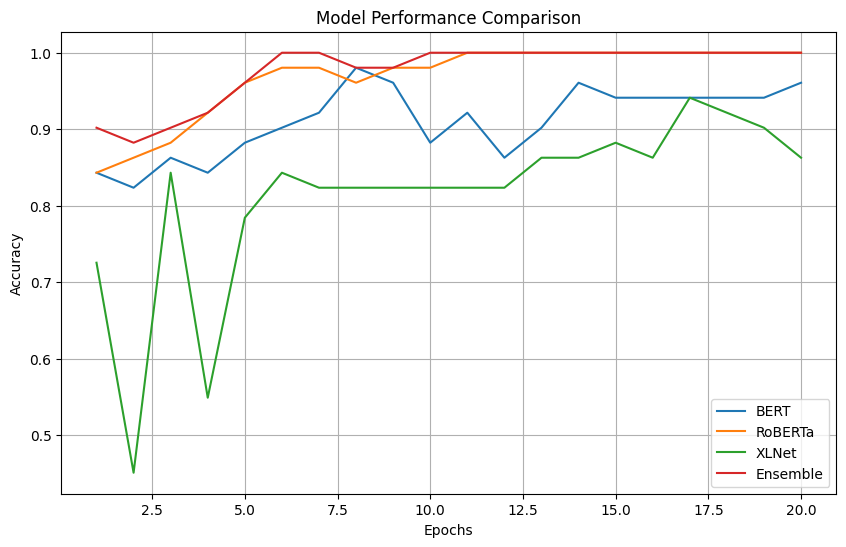

In [22]:
# Plot the performance metrics
epochs = list(range(1, 21))
plt.figure(figsize=(10, 6))
for model_name, accs in performance.items():
    plt.plot(epochs, accs, label=model_name)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Performance Comparison")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
performance

{'BERT': [0.8431372549019608,
  0.8235294117647058,
  0.8627450980392157,
  0.8431372549019608,
  0.8823529411764706,
  0.9019607843137255,
  0.9215686274509803,
  0.9803921568627451,
  0.9607843137254902,
  0.8823529411764706,
  0.9215686274509803,
  0.8627450980392157,
  0.9019607843137255,
  0.9607843137254902,
  0.9411764705882353,
  0.9411764705882353,
  0.9411764705882353,
  0.9411764705882353,
  0.9411764705882353,
  0.9607843137254902],
 'RoBERTa': [0.8431372549019608,
  0.8627450980392157,
  0.8823529411764706,
  0.9215686274509803,
  0.9607843137254902,
  0.9803921568627451,
  0.9803921568627451,
  0.9607843137254902,
  0.9803921568627451,
  0.9803921568627451,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'XLNet': [0.7254901960784313,
  0.45098039215686275,
  0.8431372549019608,
  0.5490196078431373,
  0.7843137254901961,
  0.8431372549019608,
  0.8235294117647058,
  0.8235294117647058,
  0.8235294117647058,
  0.8235294117647058,
  0.823529411764705

In [27]:
from transformers import BertForSequenceClassification, AutoModelForSequenceClassification, XLNetForSequenceClassification

bert_model = BertForSequenceClassification.from_pretrained(f"drive/MyDrive/uolfp/bert_model_epoch_8").to(device)
persian_model = AutoModelForSequenceClassification.from_pretrained(f"drive/MyDrive/uolfp/roberta_model_epoch_6").to(device)
xlnet_model = XLNetForSequenceClassification.from_pretrained(f"drive/MyDrive/uolfp/xlnet_model_epoch_17").to(device)


In [30]:
bert_features_val = extract_features(bert_model, bert_tokenizer, val_texts)
persian_features_val = extract_features(persian_model, persian_tokenizer, val_texts)
xlnet_features_val = extract_features(xlnet_model, xlnet_tokenizer, val_texts)

combined_features_val = [np.concatenate([bert, persian, xlnet]) for bert, persian, xlnet in zip(bert_features_val, persian_features_val, xlnet_features_val)]
ensemble_predictions = clf.predict(combined_features_val)

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report

def compute_metrics(true_labels, predictions):
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    auc = roc_auc_score(true_labels, predictions)

    return {
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": auc
    }

def evaluate_and_predict(model, tokenizer, dataloader):
    model.eval()
    total = 0
    correct = 0
    all_predictions = []

    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = inputs['labels'].cpu().numpy()

            all_predictions.extend(preds)
            correct += (preds == labels).sum()
            total += labels.shape[0]

    accuracy = correct / total
    return accuracy, all_predictions


bert_acc, bert_preds = evaluate_and_predict(bert_model, bert_tokenizer, bert_validation_dataloader)
roberta_acc, roberta_preds = evaluate_and_predict(persian_model, persian_tokenizer, persian_validation_dataloader)
xlnet_acc, xlnet_preds = evaluate_and_predict(xlnet_model, xlnet_tokenizer, xlnet_validation_dataloader)

bert_metrics = compute_metrics(val_labels, bert_preds)
roberta_metrics = compute_metrics(val_labels, roberta_preds)
xlnet_metrics = compute_metrics(val_labels, xlnet_preds)

print("BERT Metrics:", bert_metrics)
print("RoBERTa Metrics:", roberta_metrics)
print("XLNet Metrics:", xlnet_metrics)

ensemble_metrics = compute_metrics(val_labels, ensemble_predictions)
print("Ensemble Metrics:", ensemble_metrics)

print("BERT Classification Report:")
print(classification_report(val_labels, bert_preds))

print("RoBERTa Classification Report:")
print(classification_report(val_labels, roberta_preds))

print("XLNet Classification Report:")
print(classification_report(val_labels, xlnet_preds))

print("Ensemble Classification Report:")
print(classification_report(val_labels, ensemble_predictions))


BERT Metrics: {'Precision': 0.4827586206896552, 'Recall': 0.5, 'F1-Score': 0.49122807017543857, 'ROC-AUC': 0.42391304347826086}
RoBERTa Metrics: {'Precision': 0.5862068965517241, 'Recall': 0.6071428571428571, 'F1-Score': 0.5964912280701754, 'ROC-AUC': 0.5427018633540373}
XLNet Metrics: {'Precision': 0.6129032258064516, 'Recall': 0.6785714285714286, 'F1-Score': 0.6440677966101694, 'ROC-AUC': 0.5784161490683231}
Ensemble Metrics: {'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0, 'ROC-AUC': 1.0}
BERT Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.35      0.36        23
           1       0.48      0.50      0.49        28

    accuracy                           0.43        51
   macro avg       0.42      0.42      0.42        51
weighted avg       0.43      0.43      0.43        51

RoBERTa Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.48      0.49        23
      

In [37]:
new_texts = ["دنیا به آخر رسید و قورباغه ها پرواز میکنند", "جنگ جهانی سالهاست به پایان رسید"]


bert_encoded = bert_tokenizer(new_texts, return_tensors="pt", truncation=True, padding=True, max_length=256).to(device)
roberta_encoded = persian_tokenizer(new_texts, return_tensors="pt", truncation=True, padding=True, max_length=256).to(device)
xlnet_encoded = xlnet_tokenizer(new_texts, return_tensors="pt", truncation=True, padding=True, max_length=256).to(device)

with torch.no_grad():
    bert_logits = bert_model(**bert_encoded).logits
    roberta_logits = persian_model(**roberta_encoded).logits
    xlnet_logits = xlnet_model(**xlnet_encoded).logits

bert_preds = torch.argmax(bert_logits, dim=1).cpu().numpy()
roberta_preds = torch.argmax(roberta_logits, dim=1).cpu().numpy()
xlnet_preds = torch.argmax(xlnet_logits, dim=1).cpu().numpy()

bert_features = bert_logits.cpu().detach().numpy()
roberta_features = roberta_logits.cpu().detach().numpy()
xlnet_features = xlnet_logits.cpu().detach().numpy()

combined_features = [np.concatenate([bert, roberta, xlnet]) for bert, roberta, xlnet in zip(bert_features, roberta_features, xlnet_features)]

ensemble_preds = clf.predict(combined_features)

BERT Predictions: [1 1]
RoBERTa Predictions: [1 1]
XLNet Predictions: [1 1]
Ensemble Predictions [1 1]


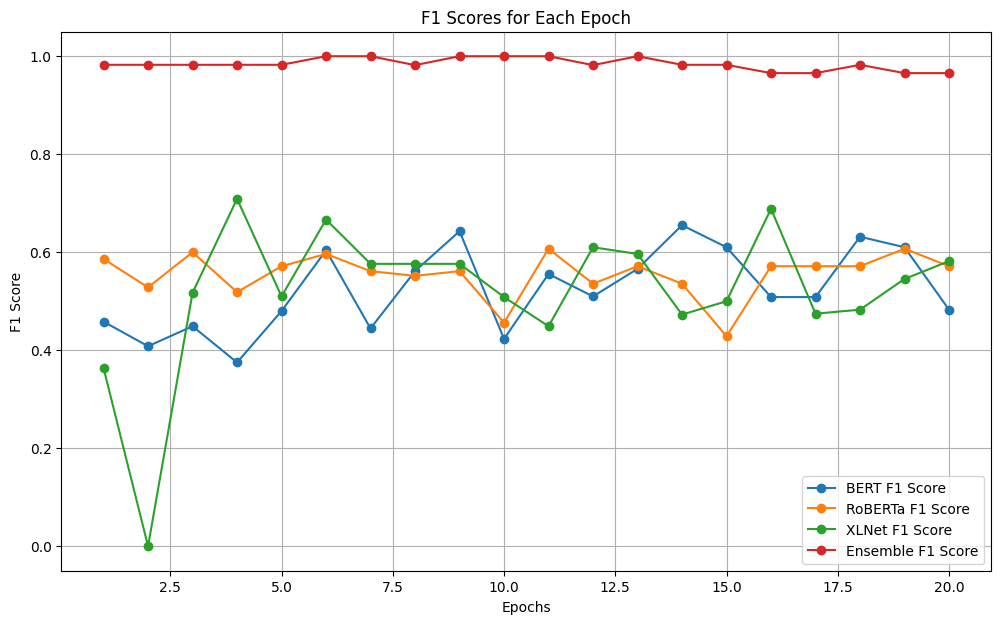

In [40]:
from transformers import BertForSequenceClassification, RobertaForSequenceClassification, XLNetForSequenceClassification

def load_model(model_type, epoch):
    if model_type == "BERT":
        model = BertForSequenceClassification.from_pretrained(f"drive/MyDrive/uolfp/bert_model_epoch_{epoch}")
    elif model_type == "RoBERTa":
        model = RobertaForSequenceClassification.from_pretrained(f"drive/MyDrive/uolfp/roberta_model_epoch_{epoch}")
    elif model_type == "XLNet":
        model = XLNetForSequenceClassification.from_pretrained(f"drive/MyDrive/uolfp/xlnet_model_epoch_{epoch}")
    model.to(device)
    return model

from sklearn.metrics import f1_score

bert_f1_scores = []
roberta_f1_scores = []
xlnet_f1_scores = []

epochs = list(range(1, 21))

for epoch in epochs:
    # Load BERT model and compute F1 score
    bert_model = load_model("BERT", epoch)
    _, bert_preds = evaluate_and_predict(bert_model, bert_tokenizer, bert_validation_dataloader)
    bert_f1_scores.append(f1_score(val_labels, bert_preds))

    # Load RoBERTa model and compute F1 score
    roberta_model = load_model("RoBERTa", epoch)
    _, roberta_preds = evaluate_and_predict(roberta_model, persian_tokenizer, persian_validation_dataloader)
    roberta_f1_scores.append(f1_score(val_labels, roberta_preds))

    # Load XLNet model and compute F1 score
    xlnet_model = load_model("XLNet", epoch)
    _, xlnet_preds = evaluate_and_predict(xlnet_model, xlnet_tokenizer, xlnet_validation_dataloader)
    xlnet_f1_scores.append(f1_score(val_labels, xlnet_preds))

import joblib

def load_ensemble_classifier(epoch):
    clf = joblib.load(f"drive/MyDrive/uolfp/clf_model_epoch_{epoch}.pkl")
    return clf

ensemble_f1_scores = []

for epoch in epochs:
    # Load BERT, RoBERTa, and XLNet models
    bert_model = load_model("BERT", epoch)
    roberta_model = load_model("RoBERTa", epoch)
    xlnet_model = load_model("XLNet", epoch)

    # Extract features for the validation set
    bert_features_val = extract_features(bert_model, bert_tokenizer, val_texts)
    roberta_features_val = extract_features(roberta_model, persian_tokenizer, val_texts)
    xlnet_features_val = extract_features(xlnet_model, xlnet_tokenizer, val_texts)
    combined_features_val = [np.concatenate([bert, persian, xlnet]) for bert, persian, xlnet in zip(bert_features_val, persian_features_val, xlnet_features_val)]

    # Load the ensemble classifier and predict
    clf = load_ensemble_classifier(epoch)
    ensemble_preds = clf.predict(combined_features_val)

    # Compute and store the F1 score for the ensemble model
    ensemble_f1_scores.append(f1_score(val_labels, ensemble_preds))

# Plot F1 scores
plt.figure(figsize=(12, 7))
plt.plot(epochs, bert_f1_scores, '-o', label='BERT F1 Score')
plt.plot(epochs, roberta_f1_scores, '-o', label='RoBERTa F1 Score')
plt.plot(epochs, xlnet_f1_scores, '-o', label='XLNet F1 Score')
plt.plot(epochs, ensemble_f1_scores, '-o', label='Ensemble F1 Score')

plt.title('F1 Scores for Each Epoch')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()


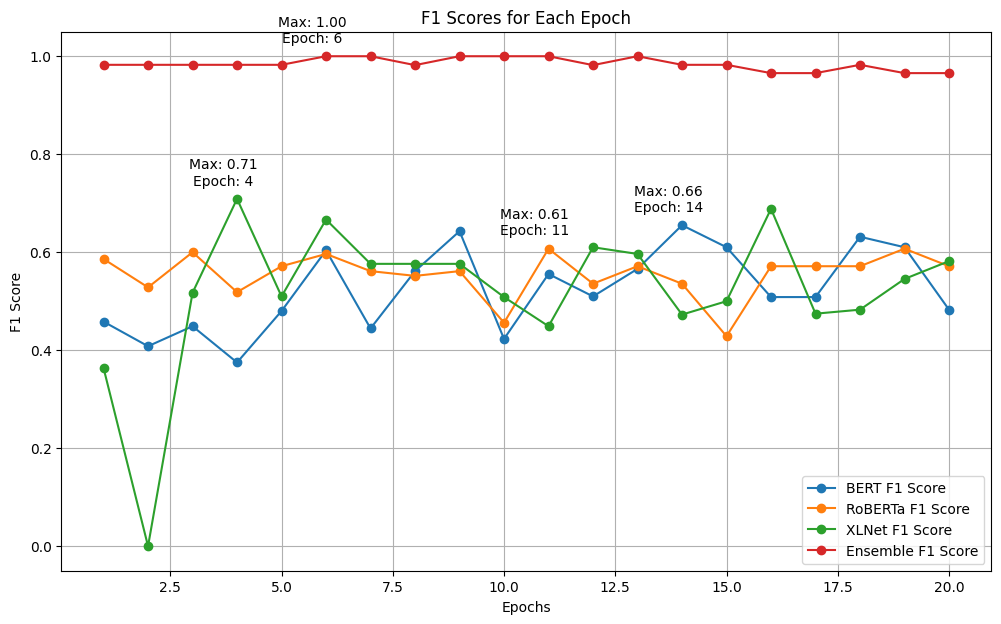

In [41]:
# Find the epoch and value of the max F1 score for each model
max_bert = max(bert_f1_scores)
max_roberta = max(roberta_f1_scores)
max_xlnet = max(xlnet_f1_scores)
max_ensemble = max(ensemble_f1_scores)

max_bert_epoch = bert_f1_scores.index(max_bert) + 1
max_roberta_epoch = roberta_f1_scores.index(max_roberta) + 1
max_xlnet_epoch = xlnet_f1_scores.index(max_xlnet) + 1
max_ensemble_epoch = ensemble_f1_scores.index(max_ensemble) + 1

# Plot F1 scores
plt.figure(figsize=(12, 7))
plt.plot(epochs, bert_f1_scores, '-o', label='BERT F1 Score')
plt.plot(epochs, roberta_f1_scores, '-o', label='RoBERTa F1 Score')
plt.plot(epochs, xlnet_f1_scores, '-o', label='XLNet F1 Score')
plt.plot(epochs, ensemble_f1_scores, '-o', label='Ensemble F1 Score')

# Annotate the max F1 score for each model
plt.annotate(f'Max: {max_bert:.2f}\nEpoch: {max_bert_epoch}',
             (max_bert_epoch, max_bert),
             textcoords="offset points",
             xytext=(-10,10),
             ha='center')

plt.annotate(f'Max: {max_roberta:.2f}\nEpoch: {max_roberta_epoch}',
             (max_roberta_epoch, max_roberta),
             textcoords="offset points",
             xytext=(-10,10),
             ha='center')

plt.annotate(f'Max: {max_xlnet:.2f}\nEpoch: {max_xlnet_epoch}',
             (max_xlnet_epoch, max_xlnet),
             textcoords="offset points",
             xytext=(-10,10),
             ha='center')

plt.annotate(f'Max: {max_ensemble:.2f}\nEpoch: {max_ensemble_epoch}',
             (max_ensemble_epoch, max_ensemble),
             textcoords="offset points",
             xytext=(-10,10),
             ha='center')

plt.title('F1 Scores for Each Epoch')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def train_ensemble_clf(selected_models, epochs, train_texts, train_labels, val_texts, val_labels, clf_params=None):
    """
    Train an ensemble classifier on features extracted from selected transformer models.

    Args:
    - selected_models (list): List of model names to be used ("BERT", "RoBERTa", "XLNet")
    - epochs (int): Number of epochs to train each model.
    - train_texts (list): Training texts.
    - train_labels (list): Training labels.
    - val_texts (list): Validation texts.
    - val_labels (list): Validation labels.
    - clf_params (dict): Parameters to initialize the ensemble classifier.

    Returns:
    - clf (LogisticRegression): Trained ensemble classifier.
    - val_accuracy (float): Accuracy of the classifier on the validation set.
    """

    # Extract features for the training set
    combined_features_train = []
    for model_name in selected_models:
        model = load_model(model_name, epochs)
        if model_name == "BERT":
            features_train = extract_features(model, bert_tokenizer, train_texts)
        elif model_name == "RoBERTa":
            features_train = extract_features(model, persian_tokenizer, train_texts)
        elif model_name == "XLNet":
            features_train = extract_features(model, xlnet_tokenizer, train_texts)
        combined_features_train.append(features_train)

    combined_features_train = np.concatenate(combined_features_train, axis=1)

    # Extract features for the validation set
    combined_features_val = []
    for model_name in selected_models:
        model = load_model(model_name, epochs)
        if model_name == "BERT":
            features_val = extract_features(model, bert_tokenizer, val_texts)
        elif model_name == "RoBERTa":
            features_val = extract_features(model, persian_tokenizer, val_texts)
        elif model_name == "XLNet":
            features_val = extract_features(model, xlnet_tokenizer, val_texts)
        combined_features_val.append(features_val)

    combined_features_val = np.concatenate(combined_features_val, axis=1)

    # Train the ensemble classifier
    if clf_params:
        clf = LogisticRegression(**clf_params)
    else:
        clf = LogisticRegression()

    clf.fit(combined_features_train, train_labels)

    # Predict and calculate accuracy on the validation set
    val_preds = clf.predict(combined_features_val)
    val_accuracy = accuracy_score(val_labels, val_preds)

    return clf, val_accuracy


In [46]:
# Modify the load_model function to accept specific epochs for each model
def load_model(model_type, epoch_dict):
    if model_type == "BERT":
        model = BertForSequenceClassification.from_pretrained(f"drive/MyDrive/uolfp/bert_model_epoch_{epoch_dict['BERT']}")
    elif model_type == "RoBERTa":
        model = RobertaForSequenceClassification.from_pretrained(f"drive/MyDrive/uolfp/roberta_model_epoch_{epoch_dict['RoBERTa']}")
    elif model_type == "XLNet":
        model = XLNetForSequenceClassification.from_pretrained(f"drive/MyDrive/uolfp/xlnet_model_epoch_{epoch_dict['XLNet']}")
    model.to(device)
    return model

# Specify the epochs for each model
epoch_dict = {
    "BERT": 14,
    "RoBERTa": 11,
    "XLNet": 4
}

# Selected models
selected_models = ["BERT", "RoBERTa", "XLNet"]

# Training parameters for the ensemble classifier
clf_params = {
    "max_iter": 1000
}

# Use the function to train the ensemble classifier
clf, val_accuracy = train_ensemble_clf(selected_models, epoch_dict, train_texts, train_labels, val_texts, val_labels, clf_params)

print(f"Validation Accuracy: {val_accuracy:.4f}")


Validation Accuracy: 0.9804


In [47]:
new_texts = [" واقعی: دنیا به آخر رسید و قورباغه ها پرواز میکنند", "جنگ جهانی سالهاست به پایان رسید"]

bert_model = BertForSequenceClassification.from_pretrained(f"drive/MyDrive/uolfp/bert_model_epoch_14").to(device)
persian_model = AutoModelForSequenceClassification.from_pretrained(f"drive/MyDrive/uolfp/roberta_model_epoch_11").to(device)
xlnet_model = XLNetForSequenceClassification.from_pretrained(f"drive/MyDrive/uolfp/xlnet_model_epoch_4").to(device)


bert_encoded = bert_tokenizer(new_texts, return_tensors="pt", truncation=True, padding=True, max_length=256).to(device)
roberta_encoded = persian_tokenizer(new_texts, return_tensors="pt", truncation=True, padding=True, max_length=256).to(device)
xlnet_encoded = xlnet_tokenizer(new_texts, return_tensors="pt", truncation=True, padding=True, max_length=256).to(device)

with torch.no_grad():
    bert_logits = bert_model(**bert_encoded).logits
    roberta_logits = persian_model(**roberta_encoded).logits
    xlnet_logits = xlnet_model(**xlnet_encoded).logits

bert_preds = torch.argmax(bert_logits, dim=1).cpu().numpy()
roberta_preds = torch.argmax(roberta_logits, dim=1).cpu().numpy()
xlnet_preds = torch.argmax(xlnet_logits, dim=1).cpu().numpy()

bert_features = bert_logits.cpu().detach().numpy()
roberta_features = roberta_logits.cpu().detach().numpy()
xlnet_features = xlnet_logits.cpu().detach().numpy()

combined_features = [np.concatenate([bert, roberta, xlnet]) for bert, roberta, xlnet in zip(bert_features, roberta_features, xlnet_features)]

ensemble_preds = clf.predict(combined_features)

In [50]:
ensemble_preds

[0, 1]

In [52]:
print("bert: " + str(bert_f1_scores))
print("persian roberta: " + str(roberta_f1_scores))
print("xlnet: " + str(xlnet_f1_scores))
print("ensemble: " + str(ensemble_f1_scores))

bert: [0.45833333333333337, 0.40816326530612246, 0.4489795918367347, 0.375, 0.4799999999999999, 0.6037735849056605, 0.4444444444444445, 0.5614035087719299, 0.6428571428571429, 0.4230769230769231, 0.5555555555555555, 0.5098039215686274, 0.5660377358490566, 0.6551724137931035, 0.6101694915254238, 0.5084745762711865, 0.5084745762711865, 0.6315789473684211, 0.6101694915254238, 0.4827586206896552]
persian roberta: [0.5862068965517241, 0.5283018867924528, 0.6, 0.5185185185185186, 0.5714285714285714, 0.5964912280701754, 0.5614035087719299, 0.5517241379310344, 0.5614035087719299, 0.456140350877193, 0.6071428571428571, 0.5357142857142857, 0.5714285714285714, 0.5357142857142857, 0.42857142857142855, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.6071428571428571, 0.5714285714285714]
xlnet: [0.36363636363636365, 0.0, 0.5172413793103449, 0.7088607594936709, 0.5098039215686274, 0.6666666666666666, 0.5762711864406779, 0.5762711864406779, 0.5762711864406779, 0.5084745762711865, 0.44897